<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    SAN Projekt:<br> Schweizer Offshore Firmen
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Tobias Buess im FS 2024.
</p>

Wir führen eine Voranalyse für das Bundesamt für Statistik durch, um die kürzlich aufgetretenen Leaks aus den Offshore Papers zu untersuchen. 

Diese Analyse zielt darauf ab, Umfang und Natur der Verbindungen in Schweizer Offshore-Strukturen zu ermitteln. Wir verwenden dafür Daten aus der [Offshore Leaks Database](https://offshoreleaks.icij.org/), um mögliche Muster, wichtige Personen aufzudecken, die für die Steuerbehörden oder Regulierungsorgane von Interesse sein könnten. 

Unsere Arbeit umfasst eine detaillierte Prüfung der betroffenen Entitäten. Dies wird es dem Bundesamt für Statistik ermöglichen, fundierte Entscheidungen zur weiteren Untersuchung und möglichen Massnahmen zu treffen.

## Imports und Einstellungen

In [1]:
# Python internal modules
import os

# Project modules
import utils

# External modules
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter


BACKEND = None  # use default
if "cugraph" in nx.utils.backends.backends.keys():
    import nx_cugraph as nxcg

    BACKEND = "cugraph"

print("Python Environment:")
print(f" | Python version: {os.sys.version}")
print(f" | Numpy version: {np.__version__}")
print(f" | Pandas version: {pd.__version__}")
print(f" | Matplotlib version: {matplotlib.__version__}")
print(f" | NetworkX version: {nx.__version__}")
print(f" | NetworkX backend: {BACKEND}")
print(
    f" | CuGraph version: {nxcg.__version__}"
    if BACKEND == "cugraph"
    else " | CuGraph not installed, for better performance install it like this:\n\tpip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com"
)
print()
print("Ressources:")
print(f" | CPU: {os.cpu_count()} cores")

PAPERS = "Pandora Papers"
GRAPH_PATH = f"./data/{PAPERS.lower().replace(' ', '_')}_graph.gexf"

Python Environment:
 | Python version: 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]
 | Numpy version: 1.26.4
 | Pandas version: 2.2.2
 | Matplotlib version: 3.8.4
 | NetworkX version: 3.3
 | NetworkX backend: None
 | CuGraph not installed, for better performance install it like this:
	pip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com

Ressources:
 | CPU: 12 cores


## Daten laden

In [2]:
# Graph mit allen Nodes/Edges von den gewählten Papers laden
G = utils.get_graph(GRAPH_PATH, PAPERS)

Info pre filtering:
Number of edges:  145874
Number of nodes:  108053
Number of weakly connected components:  2643

Filtering the graph after the country "Switzerland"

Info post filtering:
Number of edges:  127482
Number of nodes:  91864
Number of weakly connected components:  53


## Specific analysis...

In [18]:
def unweighted_project_officers_graph(G):
    # Step 1: Make the original graph undirected
    undirected_G = G.to_undirected()

    # Step 2: Project the network to obtain a graph with only officers
    officers_nodes = {node for node, data in undirected_G.nodes(data=True) if data.get("node_type") == "Officer"}

    connecting_entities = 0

    # Step 3: Connect officers if they share the same address or entity
    new_G = nx.Graph()
    for node in officers_nodes:

        # Check if the officer is related to an address or entity
        related_nodes = set()
        for neighbor in undirected_G.neighbors(node):
            neighbor_data = undirected_G.nodes[neighbor]
            if neighbor_data.get("node_type") == "Address" or neighbor_data.get("node_type") == "Entity":
                related_nodes.add(neighbor)

        # Add edges between officers if they share the same address or entity
        for related_node in related_nodes:
            for neighbor in undirected_G.neighbors(related_node):
                if neighbor in officers_nodes and neighbor != node:
                    related_data = undirected_G.nodes[related_node]
                    if related_data.get("node_type") == "Entity":
                        connecting_entities += 1
                    new_G.add_edge(node, neighbor)

    return new_G, connecting_entities

# Create the new graph
new_officers_graph, connecting_entities = unweighted_project_officers_graph(G)

In [37]:
# List the number of edges and nodes
num_nodes = len(new_officers_graph.nodes)
num_edges = len(new_officers_graph.edges)

print("Number of nodes in the new officers graph:", num_nodes)

all_officers_nodes = {node for node, data in G.nodes(data=True) if data.get("node_type") == "Officer"}

swiss_officers_nodes = {node for node, data in G.nodes(data=True) if utils.is_officer_from_country_name(G, node, "Switzerland")}

swiss_officers_to_all_officers_ratio = len(swiss_officers_nodes)/len(all_officers_nodes)

print(f"Ratio of swiss officers: {swiss_officers_to_all_officers_ratio}")
print()

print("Number of edges in the new officers graph:", num_edges)
print(f"Number of edges in the new officers graph which stem from entities: {connecting_entities} ({connecting_entities/num_edges:.2%})")
print(f"Number of edges in the new officers graph which stem from addresses: {num_edges-connecting_entities} ({(num_edges-connecting_entities)/num_edges:.2%})")
print()

# Calculate the ratio of edges to the number of maximally possible edges
max_possible_edges = num_nodes * (num_nodes - 1) / 2  # Complete graph formula
edge_ratio = num_edges / max_possible_edges if max_possible_edges > 0 else 0  # To handle division by zero

print("Edge ratio (edges / max possible edges):", edge_ratio, "which is equivalent to", edge_ratio * 100, "%")


Number of nodes in the new officers graph: 40317
Ratio of swiss officers: 0.024676920637437566

Number of edges in the new officers graph: 448609
Number of edges in the new officers graph which stem from entities: 93536 (20.85%)
Number of edges in the new officers graph which stem from addresses: 355073 (79.15%)

Edge ratio (edges / max possible edges): 0.0005519914268665788 which is equivalent to 0.05519914268665788 %


The new graph consists of 40k Officers (of which 86% are Swiss) and 448k Connections between them. More than 20% of the newly created edges between the officers don't stem from addresses but from entities they are connected to. This is important. Because officers having the same address will be a clique for sure and the ratio of swiss officers will be 100% or 0% depending on the address. But the fact that entities are also a connecting factor, makes the graph even interesting in the first place. As that's the only source where cliques can be multinational.

In [20]:
def plot_swiss_officer_ratios_by_group(G, G_swiss, group_callback, grouping_method):
    # Step 1: Get all groups using the provided callback
    groups = list(group_callback(G))

    # Step 2: Get all Swiss officers
    swiss_officers = {node for node, data in G_swiss.nodes(data=True) if data.get("node_type") == "Officer"}

    # Step 3: Calculate the ratio of Swiss officers for each group size
    swiss_ratio_by_size = {}
    groups_ratios = []

    for group in groups:
        group_size = len(group)
        
        swiss_count = sum(1 for node in group if node in swiss_officers)
        swiss_ratio = swiss_count / group_size if group_size > 0 else 0
        
        # Skip groups with size 1
        if group_size > 1:
            groups_ratios.append(swiss_ratio)
        
        if group_size not in swiss_ratio_by_size:
            swiss_ratio_by_size[group_size] = {"total_groups": 0, "swiss_count": 0}
        
        swiss_ratio_by_size[group_size]["total_groups"] += 1
        swiss_ratio_by_size[group_size]["swiss_count"] += swiss_count

    # Step 4: Calculate the ratio of Swiss officers for each group size
    for size, data in swiss_ratio_by_size.items():
        total_groups = data["total_groups"]
        swiss_count = data["swiss_count"]
        swiss_ratio = swiss_count / (total_groups * size) if total_groups > 0 else 0
        swiss_ratio_by_size[size]["swiss_ratio"] = swiss_ratio
        
    # Plot histogram and distribution of Swiss officer ratios in groups
    fig, ax = plt.subplots(1, 2, figsize=(24, 6))
    plt.sca(ax[0])
    plt.hist(groups_ratios, edgecolor='black', alpha=0.7)
    ratio_dist = np.unique(groups_ratios)
    plt.title(f'Distribution of Swiss Officer Ratio in {grouping_method.capitalize()}\n'
              f'Number of unique ratios: {len(ratio_dist)} first five ratios: {ratio_dist[:5] if len(ratio_dist) > 5 else ratio_dist}')
    plt.xlabel('Swiss Officer Ratio')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Extract group sizes and Swiss ratios
    group_sizes = sorted(swiss_ratio_by_size.keys())
    swiss_ratios = [swiss_ratio_by_size[size]['swiss_ratio'] for size in group_sizes]
    group_counts = [swiss_ratio_by_size[size]['total_groups'] for size in group_sizes]

    # Plot the distribution as a bar plot with categorical x-axis
    plt.sca(ax[1])
    bars = plt.bar([str(size) for size in group_sizes], swiss_ratios)
    plt.title(f'Distribution of Swiss Officer Ratio by {grouping_method.capitalize()} Size\n'
              f'(Number of {grouping_method}s: {len(groups)})')
    plt.xlabel(f'{grouping_method.capitalize()} Size')
    plt.ylabel('Mean Swiss Officer Ratio')
    plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
    plt.grid(axis='y')

    # Add average line for Swiss officers ratio of 0.85 (assuming the ratio is given)
    plt.axhline(y=swiss_officers_to_all_officers_ratio, color='red', linestyle='--', label=f'Average Swiss Officer Ratio ({swiss_officers_to_all_officers_ratio:.3f})')
    plt.legend()

    # Add group counts as text labels inside the bars
    for bar, count in zip(bars, group_counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, count, ha='center', va='top', rotation=90, color="white")

    plt.tight_layout()
    plt.show()

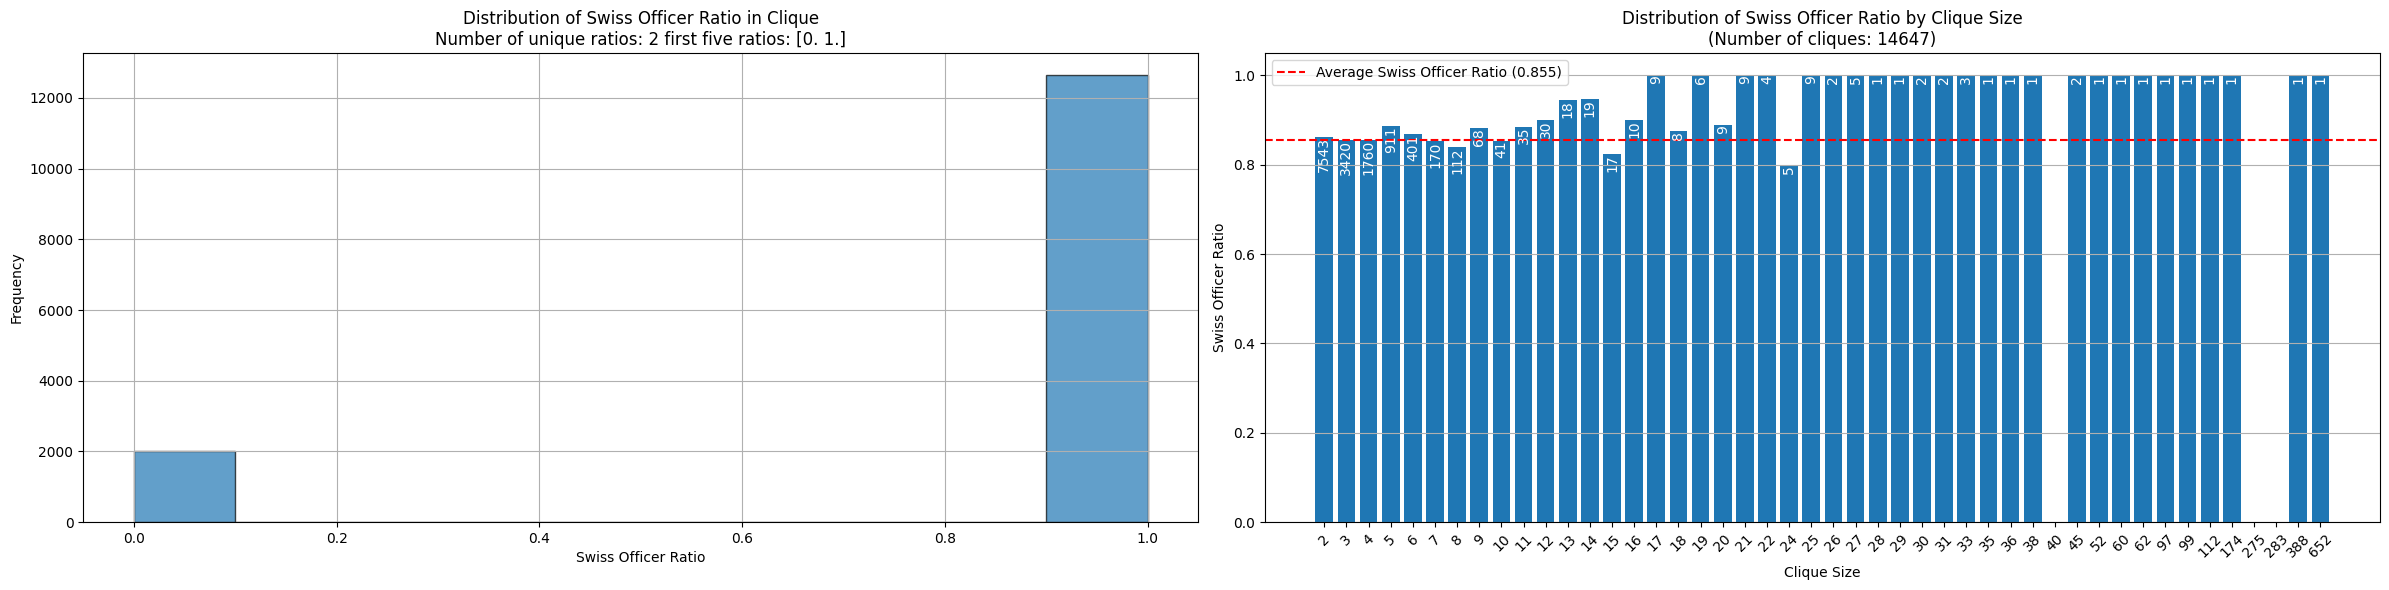

In [21]:
plot_swiss_officer_ratios_by_group(new_officers_graph, G_swiss, nx.find_cliques, 'clique')

Cliques are always swiss or not. And the rest of the cliques must most likely always be from a single country.

So entities don't connect officers in a way to create multinational cliques.

Also the ratio in the distribution of clique sizes doesnst reveal any interesting patterns.

We'll try to relax the condition a little bit and see what happens with n-cliques.

In [34]:
from networkx.algorithms.community import k_clique_communities, fast_label_propagation_communities, louvain_communities

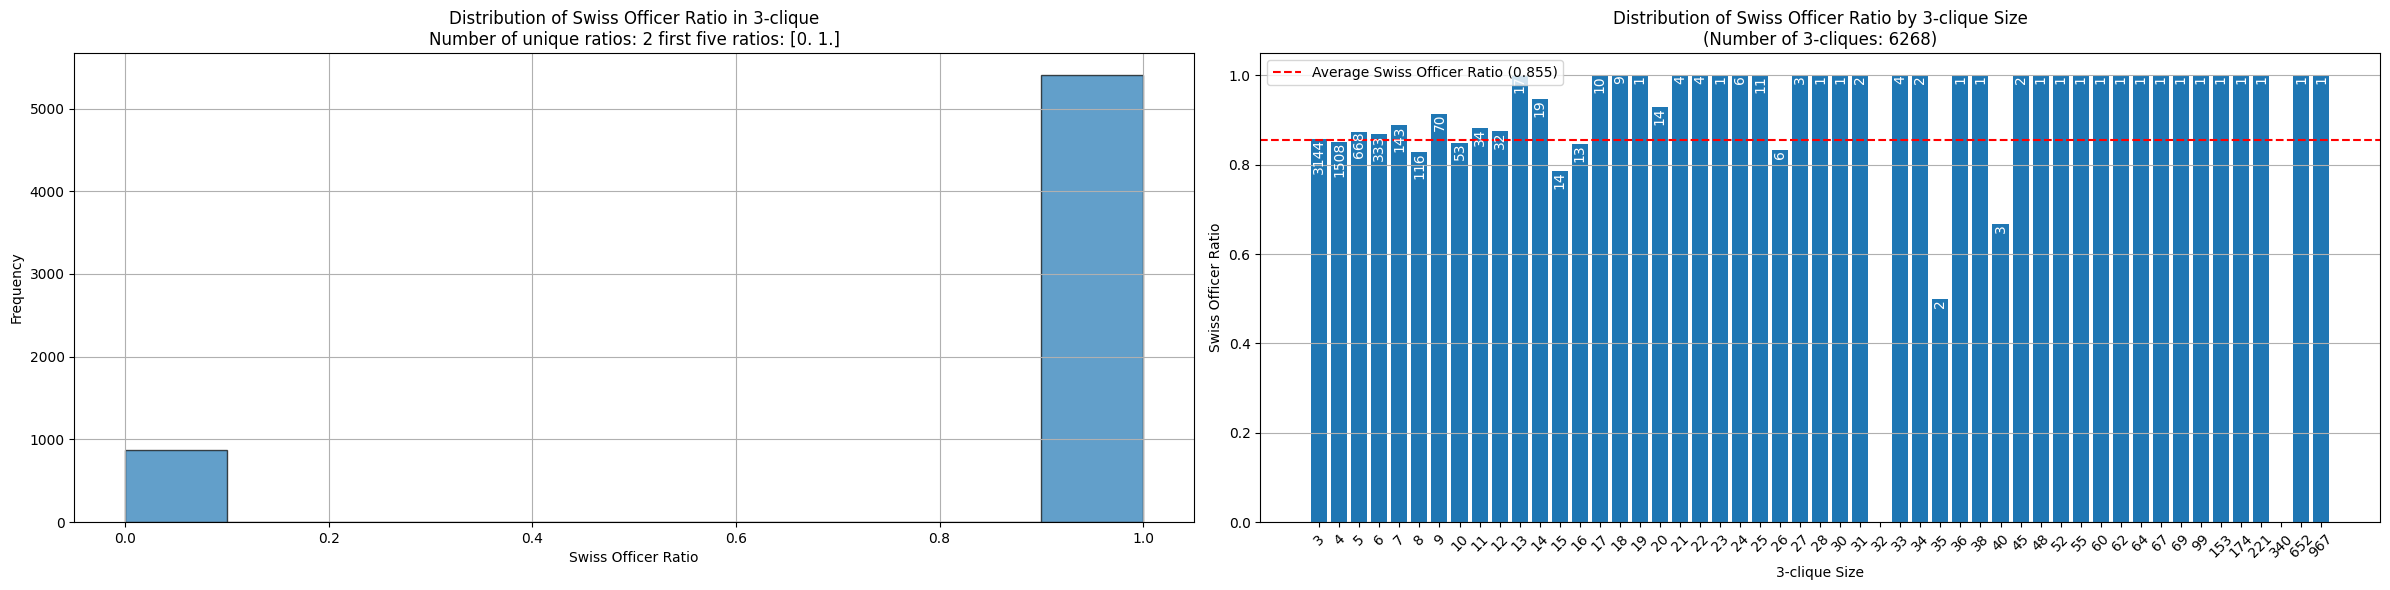

In [22]:
n = 3  # Example value for n
plot_swiss_officer_ratios_by_group(new_officers_graph, G_swiss, lambda G: k_clique_communities(G, n), f'{n}-clique')

Nothing to exiciting here. Try with the smallest n-cliques (2-cliques) and see if there are any interesting patterns.

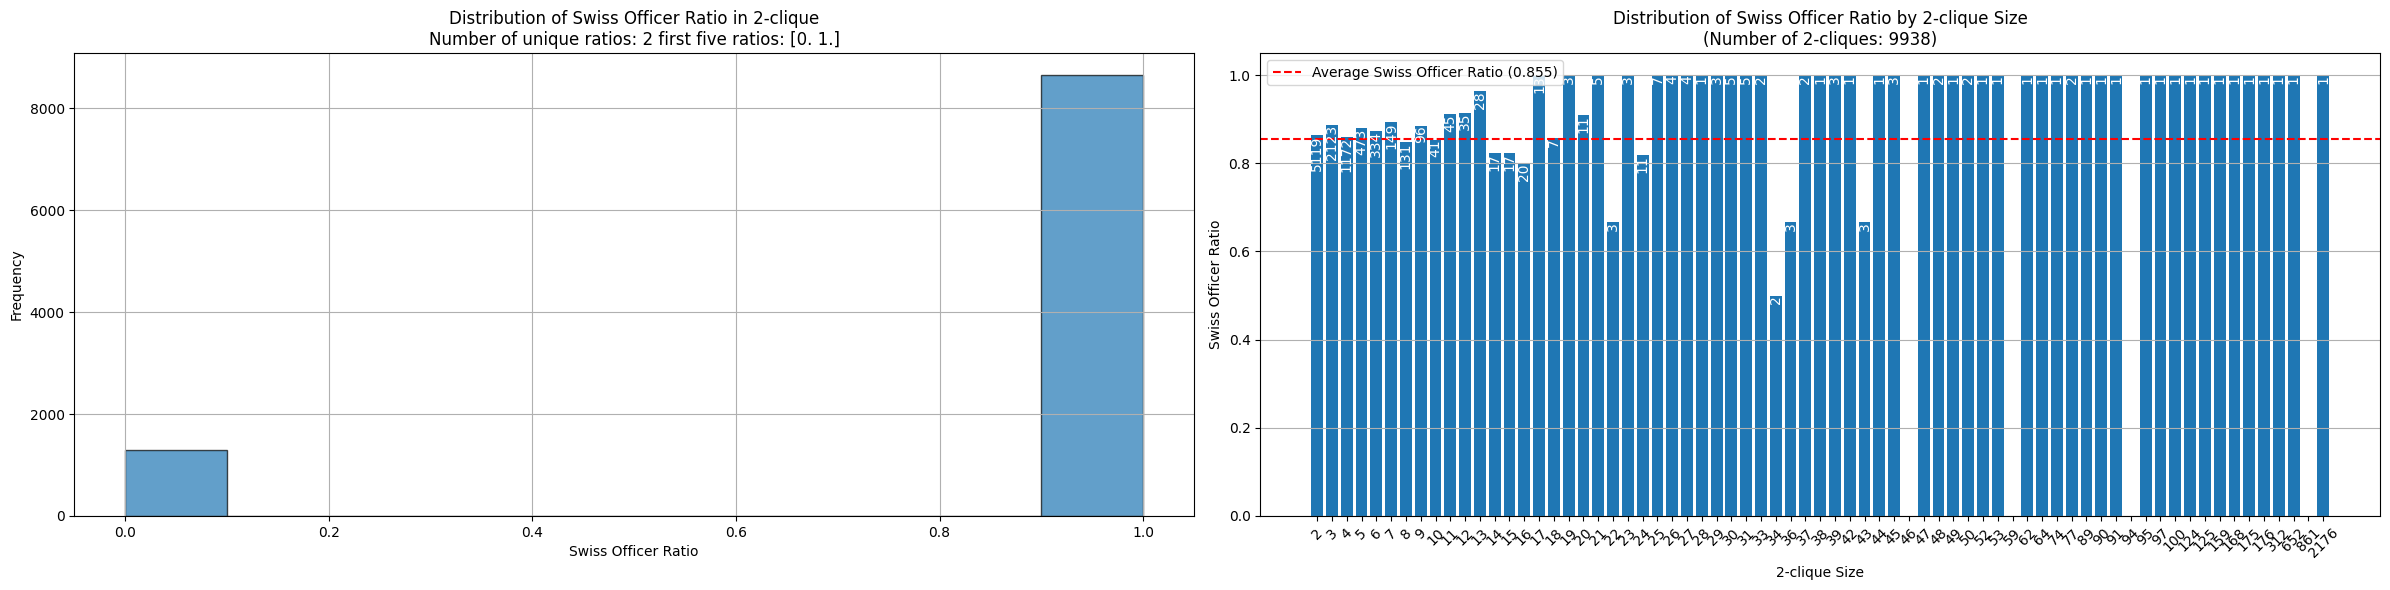

In [23]:
n = 2  # Example value for n
plot_swiss_officer_ratios_by_group(new_officers_graph, G_swiss, lambda G: k_clique_communities(G, n), f'{n}-clique')

Nope still only swiss and non swiss cliques. No mixed cliques.

Relax the condition even more with k-cores and see if there are any interesting patterns.

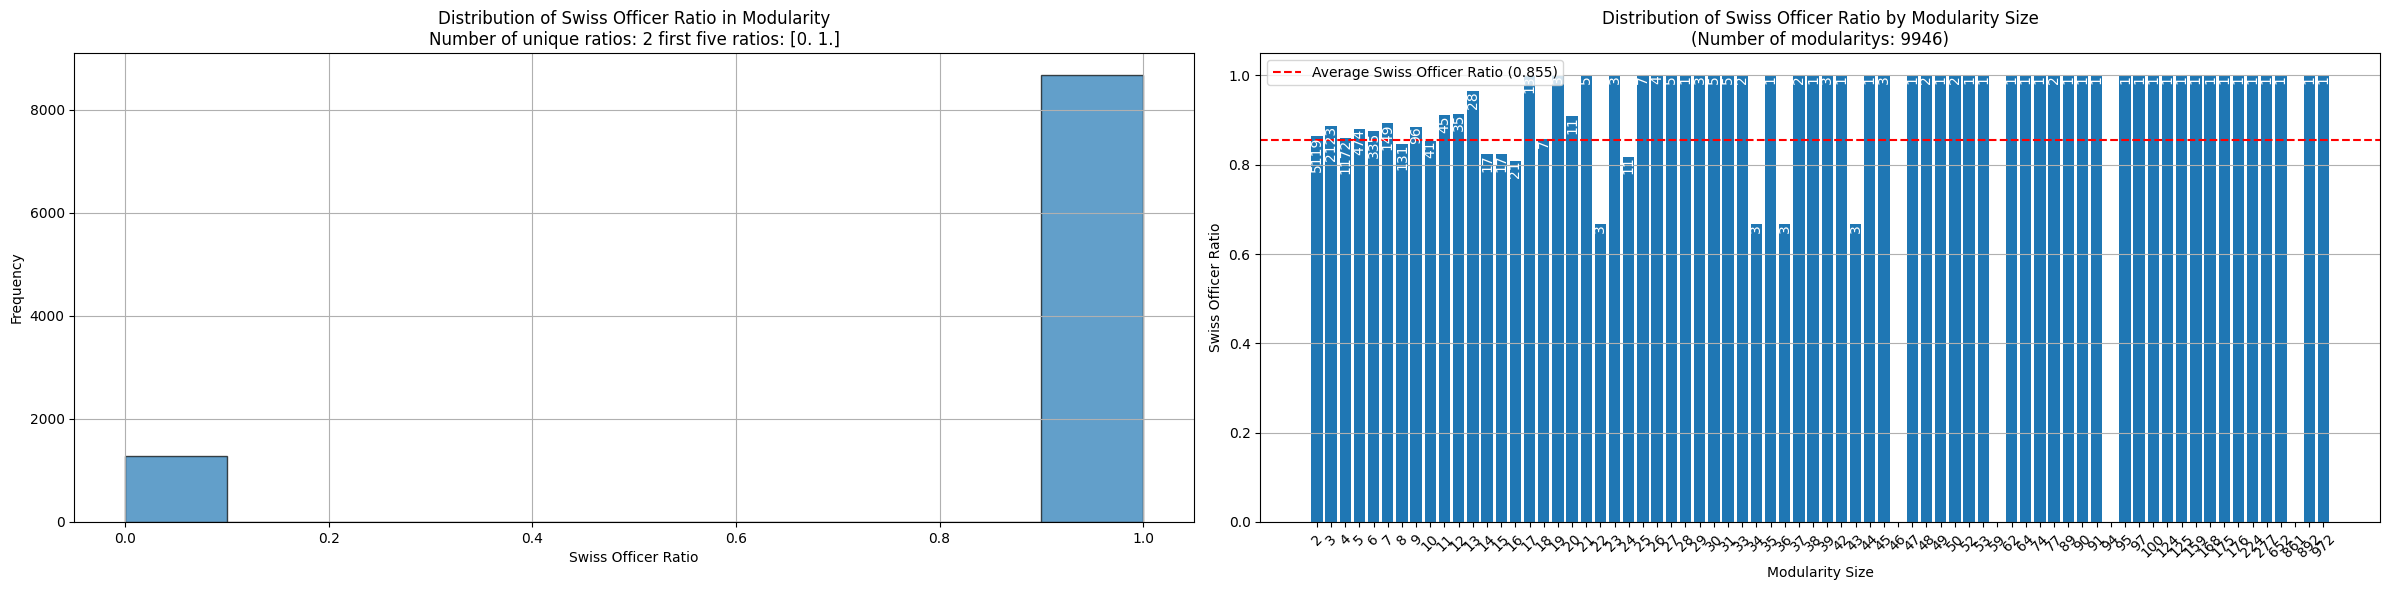

In [30]:
from networkx.algorithms.community import greedy_modularity_communities

plot_swiss_officer_ratios_by_group(new_officers_graph, G_swiss, greedy_modularity_communities, 'modularity')

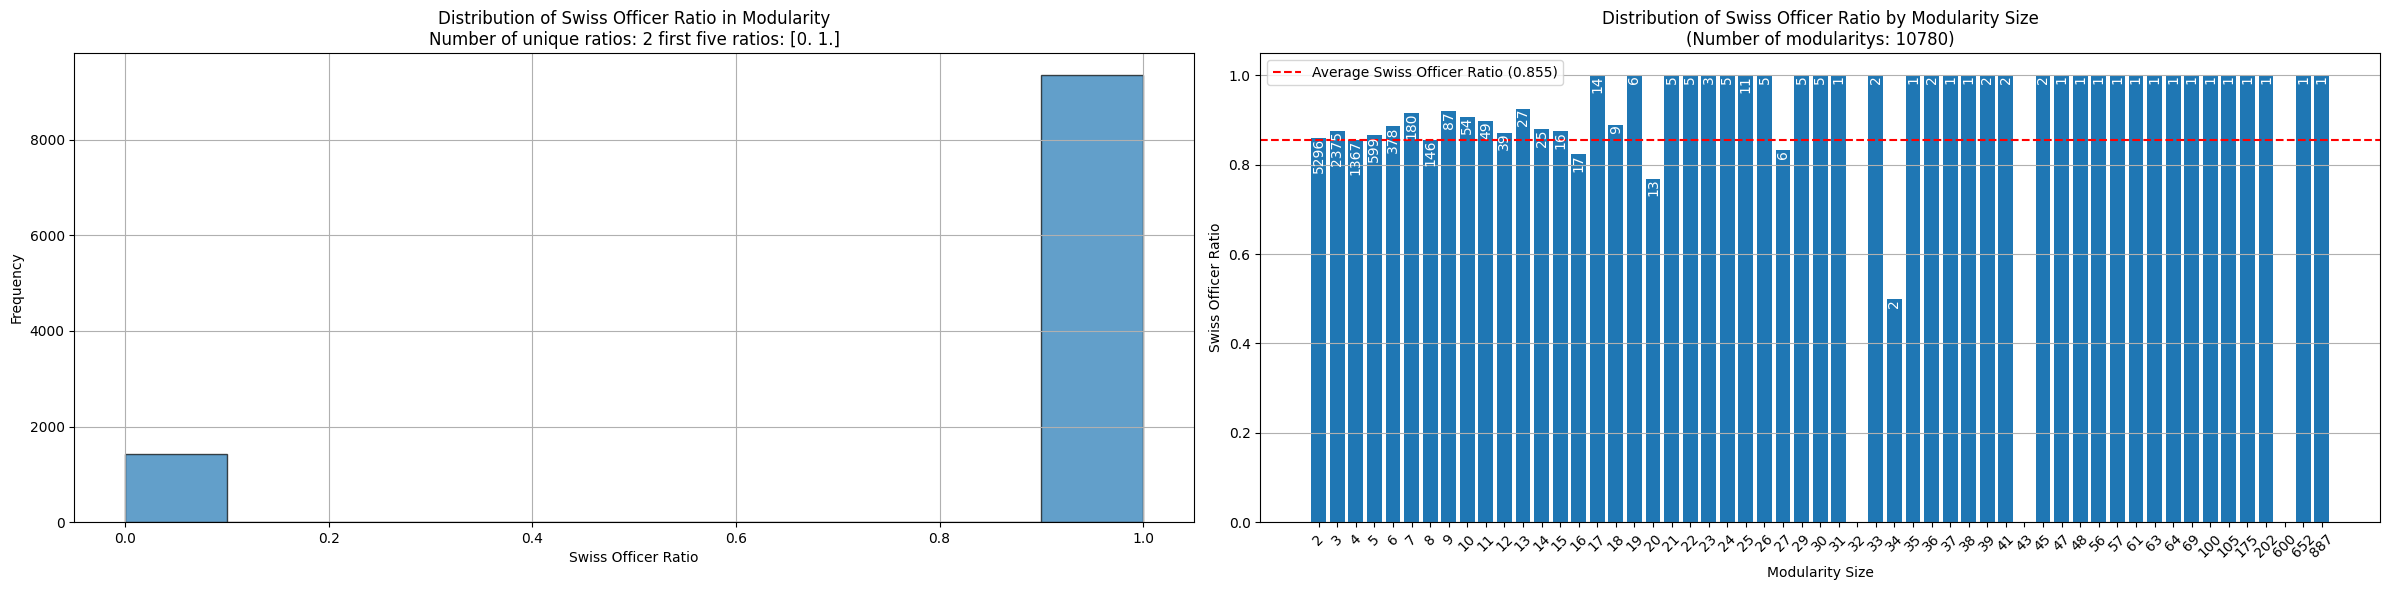

In [32]:

plot_swiss_officer_ratios_by_group(new_officers_graph, G_swiss, fast_label_propagation_communities, 'label propagation') 

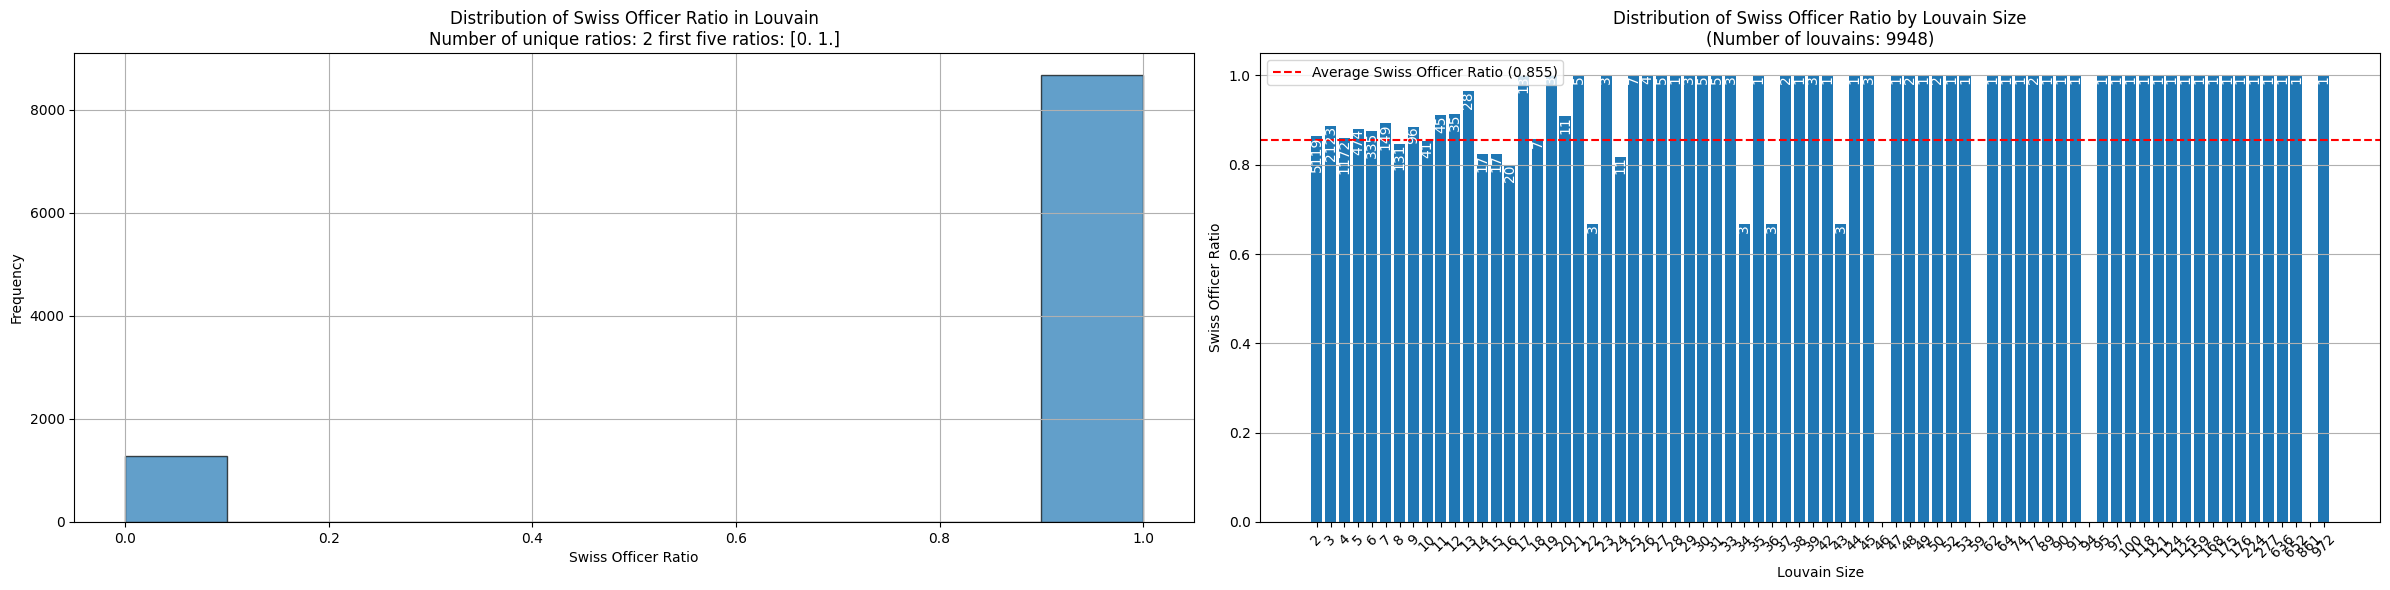

In [35]:
plot_swiss_officer_ratios_by_group(new_officers_graph, G_swiss, louvain_communities, 'louvain')

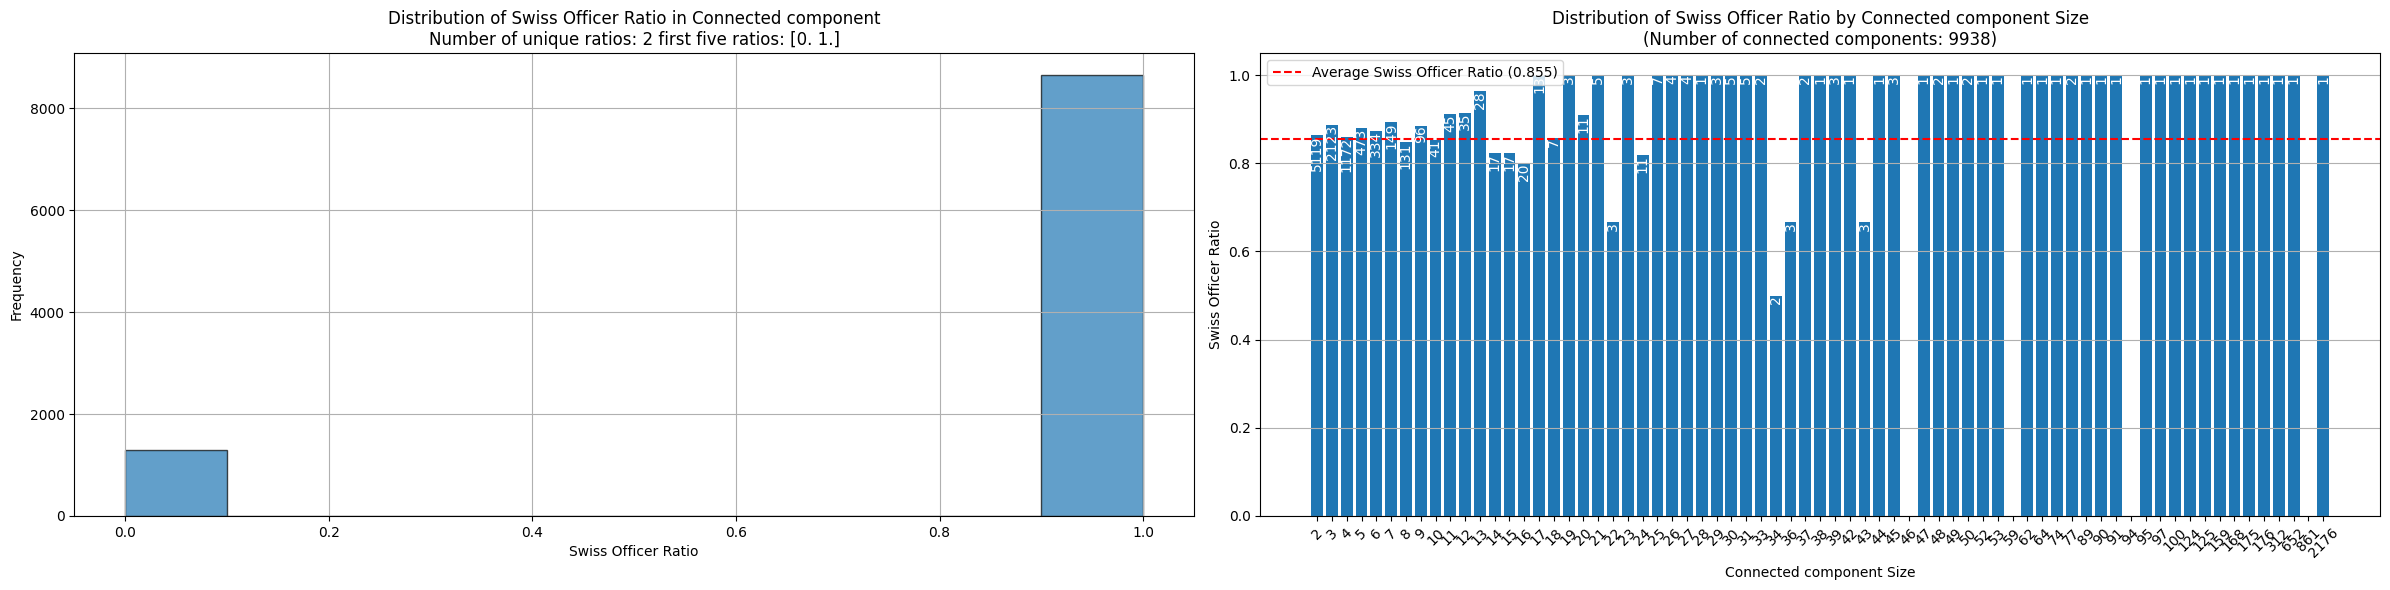

In [36]:
from networkx.algorithms.components import connected_components

plot_swiss_officer_ratios_by_group(new_officers_graph, G_swiss, connected_components, 'connected component')

This shows that there will never be a community that is mixed. It's always either swiss or not swiss.